In [1]:
# study website http://karpathy.github.io/2015/05/21/rnn-effectiveness/

![种类](img/classifier.png)

- 像图片分类 一对一
- 像图像中物体识别 一对多
- 像情感分析 多对一
- 像翻译 多对多
- 实时翻译 多对多

![char](img/mini-char-example.png)

 $$\begin{split}h_{t} &=tanh(W_{hx}x+W_{hh}h_{t-1}) \\ y &= softmax(W_{yh}h)\end{split}$$
 - 定义好损失函数，就可以让下一个字符对应的位置尽可能地大，这样子在预测的时候就可以去向量中最大的值的索引做为待预测值的索引

## 交叉损失函数
$$ J = - \sum_{c=1}^{M}y_{c}log(p_{c})$$
- M——类别的数量；
- y——指示变量（0或1）,如果该类别和样本的类别相同就是1，否则是0；
- p——对于观测样本属于类别c的预测概率。

### [DL 最全的优化方法](https://zhuanlan.zhihu.com/p/22252270)

![adagrad](img/adagrad.jpg)
- 采用累积平方梯度
- 优点是使得更新的更加平缓，更新速度更快
- 缺点是由于是累积平方梯度，导致学习率为0

### mnist_实验, numpy

In [19]:
#### 定义一些参数
import numpy as np
learning_rate = 1e-3
batch_size = 1000
from time import time
from numpy.linalg import *
# unite_size = 
from tensorflow.examples.tutorials.mnist import input_data

In [20]:
mn = input_data.read_data_sets('MNIST_DATA',one_hot = True)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [21]:
num_iterator = 20000;
time_step = 28
hidden_size = 400
feature_size = 28
import matplotlib.pyplot as plts

In [22]:
# def tanh(X):
#     Y = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
#     return Y

![tanh_overflow](img/tanh_overflow.png)

In [23]:
# def sigmod(X): ### nice
#     return .5 * (1 + np.tanh(.5 * X))

In [24]:
def softmax(X):
    sum_ = np.sum(np.exp(X), axis = 0)
    y = np.exp(X) / sum_
    return y

![adam](img/adam.png)

In [30]:
### 这里参数矩阵的大小如何定义？每一个点为特征进行的加权
### [hidden_size,feature_size]
# Wx = np.random.standard_normal([hidden_size,feature_size])
# ### [hidden_size,hidden_size]
# Wh = np.random.standard_normal([hidden_size,hidden_size])
# bh = np.zeros([hidden_size,1])
# ### [class_size,hidden_size]
# Wy = np.random.standard_normal([10,hidden_size])
# by = np.zeros([10,1])
beta1 = 0.9
beta2 = 0.999
t = 0
decay_step = 1000
decay_rate = 0.96
def init_params():
    params = {}
    params['h0'] = np.zeros([hidden_size,batch_size])
    
    params['Wx'] = np.random.standard_normal([hidden_size,feature_size])
    params['Wh'] = np.random.standard_normal([hidden_size,hidden_size])
    
    params['bh'] = np.random.standard_normal([hidden_size,1])
    
    params['mWx_m'] = np.zeros_like(params['Wx'])
    params['mWh_m'] = np.zeros_like(params['Wh'])
    params['mbh_m'] = np.zeros_like(params['bh'])
    
    params['mWx_v'] = np.zeros_like(params['Wx'])
    params['mWh_v'] = np.zeros_like(params['Wh'])
    params['mbh_v'] = np.zeros_like(params['bh'])
    
    params['Wy'] = np.random.standard_normal([10,hidden_size])
    
    params['by'] = np.random.standard_normal([10,1])
    
    params['mWy_m'] = np.zeros_like(params['Wy'])
    params['mWy_v'] = np.zeros_like(params['Wy'])
    
    params['mby_m'] = np.zeros_like(params['by'])
    params['mby_v'] = np.zeros_like(params['by'])
    return params

def forward(X,label,params):
    global t,beta1,beta2
#     print(beta1, beta2)
    t += 1
    X = X.reshape(-1,time_step,feature_size)
    
    for i in range(time_step): ## 每一步拿出所有数据的第一行来进行训练
        x = X[:,i,:]
        params['h' + str(i + 1)] = np.tanh(np.dot(params['Wh'], params['h'+ str(i)]) + params['bh'] + np.dot(params['Wx'],x.transpose()))
        
    y = softmax(np.dot(params['Wy'] ,params['h' + str(time_step)]) + params['by'])
    
    y_pred = y

    index = label.argmax(axis = 1)
    y_pred[index,range(y_pred.shape[1])] -= 1
    y_pred /= batch_size 
    
    dwy = np.dot(y_pred, params['h' + str(time_step)].transpose())
    dby = np.sum(y_pred, axis = 1,keepdims = True)
    dht = np.dot(params['Wy'].transpose(), y_pred)
    
#     params['mWy'] += dwy * dwy
#     params['mby'] += dby * dby
    params['mWy_m'] = beta1 *  params['mWy_m'] + (1 - beta1) * dwy
    params['mWy_v'] = beta2 * params['mWy_v'] + (1 - beta2) * dwy * dwy
    mWy_m_tmp = params['mWy_m'] / (1 - np.power(beta1, t))
    mWy_v_tmp =  params['mWy_v'] / (1 - np.power(beta2, t))
    
    params['mby_m'] = beta1 *  params['mby_m'] + (1 - beta1) * dby
    params['mby_v'] = beta2 * params['mby_v'] + (1 - beta2) * dby * dby
    mby_m_tmp = params['mby_m'] / (1 - np.power(beta1, t))
    mby_v_tmp =  params['mby_v'] / (1 - np.power(beta2, t))
    
    params['Wy'] += -learning_rate * np.power(decay_rate, t / decay_step) * mWy_m_tmp / (np.sqrt(mWy_v_tmp) + 1e-8)
    params['by'] += -learning_rate * np.power(decay_rate, t / decay_step) * mby_m_tmp / (np.sqrt(mby_v_tmp) + 1e-8)
    
    dwh_tmp = np.zeros_like(params['Wh'])
    dbh_tmp = np.zeros_like(params['bh'])
    dwx_tmp = np.zeros_like(params['Wx'])
    
    
#     X = X.reshape(-1,time_step,feature_size)
    ## 会出现梯度消失的问题
    
    ## 将对应的偏 ht/ 偏ht-1 等于1
    
    for i in reversed(range(time_step)):
        x = X[:,i,:]
        dt = np.dot(np.diag(1 - (params['h' + str(i + 1)] ** 2)), dht)
        dt_t_1_h = np.dot(dt , params['h' + str(i)].transpose()) ## be careful 
        dt_t_1_x = np.dot(dt , x)
        dt_t_1_b = np.sum(dt * dht, axis = 1, keepdims = True)

        dwh_tmp += dt_t_1_h
        dbh_tmp += dt_t_1_b
        dwx_tmp += dt_t_1_x
    ### 使用等于0的算法
    
#     dt = (1 - (params['h' + str(time_step)] ** 2)) * dht
#     dt_t_1_h = np.dot(dt , params['h' + str(i)].transpose()) ## be careful 
#     dt_t_1_x = np.dot(dt , x)
#     dt_t_1_b = np.sum(dt * dht, axis = 1, keepdims = True)

    dt_t_1_h = dwh_tmp
    dt_t_1_b = dbh_tmp
    dt_t_1_x = dwx_tmp
    
    params['mWx_m'] = beta1 *  params['mWx_m'] + (1 - beta1) * dt_t_1_x
    params['mWx_v'] = beta2 * params['mWx_v'] + (1 - beta2) * dt_t_1_x * dt_t_1_x
    mWx_m_tmp = params['mWx_m'] / (1 - np.power(beta1, t))
    mWx_v_tmp =  params['mWx_v'] / (1 - np.power(beta2, t))
    
    params['mWh_m'] = beta1 *  params['mWh_m'] + (1 - beta1) * dt_t_1_h
    params['mWh_v'] = beta2 * params['mWh_v'] + (1 - beta2) * dt_t_1_h * dt_t_1_h
    mWh_m_tmp = params['mWh_m'] / (1 - np.power(beta1, t))
    mWh_v_tmp =  params['mWh_v'] / (1 - np.power(beta2, t))
    
    params['mbh_m'] = beta1 *  params['mbh_m'] + (1 - beta1) * dt_t_1_b
    params['mbh_v'] = beta2 * params['mbh_v'] + (1 - beta2) * dt_t_1_b * dt_t_1_b
    mbh_m_tmp = params['mbh_m'] / (1 - np.power(beta1, t))
    mbh_v_tmp =  params['mbh_v'] / (1 - np.power(beta2, t))
#     print('梯度:',norm(mWx_m_tmp / np.sqrt(mWx_v_tmp)), norm(mWh_m_tmp / np.sqrt(mWh_v_tmp))) 
    wx_cut = mWx_m_tmp / (np.sqrt(mWx_v_tmp) + 1e-8)
    wh_cut = mWh_m_tmp / (np.sqrt(mWh_v_tmp) + 1e-8)
    bh_cut = mbh_m_tmp / (np.sqrt(mbh_v_tmp) + 1e-8)
    if norm(wx_cut) > 2:
        wx_cut = 2 * wx_cut / norm(wx_cut)
    if norm(wh_cut) > 2:
        wh_cut = 2 * wh_cut / norm(wh_cut)
    if norm(bh_cut) > 2:
        bh_cut = 2 * bh_cut / norm(bh_cut)
    
    params['Wx'] = -learning_rate  * np.power(decay_rate, t / decay_step) * wx_cut
    params['Wh'] = -learning_rate * np.power(decay_rate, t / decay_step) * wh_cut
    params['bh'] = -learning_rate * np.power(decay_rate, t / decay_step) * bh_cut

# #  adagrad 梯度
#     params['mWx'] += dwx_tmp * dt_t_1_x
#     params['mWh'] += dwh_tmp * dt_t_1_h
#     params['mbh'] += dbh_tmp * dt_t_1_b
#     params['Wx'] = -learning_rate * dwx_tmp / np.sqrt(params['mWx']  + 1e-8)
#     params['Wh'] = -learning_rate * dwh_tmp / np.sqrt(params['mWh']  + 1e-8)
#     params['bh'] = -learning_rate * dbh_tmp / np.sqrt(params['mbh']  + 1e-8)

    return params
def predict(X, params):
    X = X.reshape(-1,time_step,feature_size)
    for i in range(time_step): ## 每一步拿出所有数据的第一行来进行训练
        x = X[:,i,:]
        params['h' + str(i + 1)] = np.tanh(np.dot(params['Wh'], params['h'+ str(i)]) + params['bh']  + np.dot(params['Wx'],x.transpose()))
    y = softmax(np.dot(params['Wy'],params['h' + str(time_step)]) + params['by'])
    return y

In [35]:
loss_list = []
params = init_params()
start = time()
train_data,train_label = mn.train.next_batch(batch_size) ### random
for iterator in range(num_iterator):

    params = forward(train_data,train_label,params)
    pred_y = predict(train_data,params)
    
    result = np.dot(train_label,pred_y)
    result[result < 1e-8] = 1e-8
    result[result >= 1] = 0.99999
    loss = - np.trace(np.log(result))
#     if iterator % 20 == 0:
#         print(loss/batch_size)
    loss_list.append(loss/batch_size)
print(time() - start)

In [246]:
# pred_y = predict(train_data,params)

In [247]:
# index = train_label.argmax(axis = 1)
# -np.sum(np.log(pred_y[index,range(pred_y.shape[1])]))

227.923778637185

In [32]:
import matplotlib.pyplot as plt

In [33]:
# 使用SGD 会loss 函数会上下抖动。
## 确实可以收敛，但是不是收敛到最小，所以还是有点问题
## 只是说这里逐渐趋于稳定，但是不逐渐减小

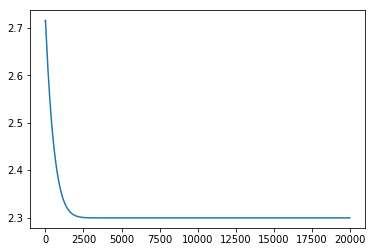

In [34]:
plt.plot(range(len(loss_list)), loss_list)
plt.savefig('rnn.png')

In [120]:
np.min(loss_list)

2285.793159361234

In [121]:
test_x,test_y = mn.test.next_batch(batch_size)
y = predict(test_x,params)

In [122]:
y.shape

(10, 1000)

In [123]:
np.mean(np.argmax(y, axis = 0) == np.argmax(test_y,axis = 1))

0.123

### 总结
- 该$RNN$中涉及的求导公式主要有
    - $tanh(x) = 1 - tanh^{2}(x)$
    - $\frac{\partial WX}{\partial W} = X^{T}, \frac{\partial WX}{\partial X} = W^{T}$
    - softmax 的求导。$S_{j} = \frac{e_{j}}{\sum_{i=0}^{n} e_{i}}$
        - 当 $i!=j$时，$\frac{\partial S_{j}}{\partial i} = -S_{i}S_{j}$
        - 当 $i == j$时，$\frac{\partial S_{i}}{\partial i} = S_{i} \times (1 - S_{i})$
- 果然自己手写RNN,还是会有很多的问题的，比如梯度消失，爆炸，函数的定义，我竟然想着在每一个时刻都用一个$Wx$和$Wh$来作为参数，这真的是愚蠢之极。
- 关于梯度消失的问题是因为你逐渐求导的话，会出现$\prod_{k = 0}^{t} H'(t) Wh$,因为$H'(t)$是小于等于1的，而$H'(t)$中的数值一般也是小于零的，所以随着时间的推移，该值会逐渐减小，所以会出现梯度消失的情况。
- 虽然收敛了，但是为什么就只收敛了一部分？这还是一个问题！！

### 速度实验验证
- $$\begin{array}{c|ccc} 
result(s) & local & Kaggle & google \\
\hline
CPU & 110.7 & 305.9 & 415.2
\end{array}$$

- $$\begin{array}{c|ccc} 
result(s) & local(CPU) & Kaggle & google \\
\hline
GPU &  91.7 & 38.7 & 66.93
\end{array}$$
- 在相同的数据下进行的实验。

In [3]:
import numpy as np
arr = np.array([1,2,3])
A = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [8]:
arr * A

array([[ 1,  4,  9],
       [ 4, 10, 18],
       [ 7, 16, 27]])

In [5]:
np.dot(,A)

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 27]])

In [6]:
np.diag(arr)

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [18]:
np.norm([1,2,3])

AttributeError: module 'numpy' has no attribute 'norm'